In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn import preprocessing 
import numpy as np
import os

In [2]:
cwd = os.getcwd()
test_set = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/test_data.csv')))
dataset = pd.DataFrame(pd.read_csv(os.path.join(cwd, 'datasets/train_data.csv')))

In [3]:
dataset.head()

,ID,parents,has_nurs,form,children,housing,finance,social,health,app_status
0,1,usual,less_proper,complete,3,critical,convenient,problematic,not_recom,0
1,2,pretentious,very_crit,completed,1,convenient,inconv,nonprob,not_recom,0
2,3,pretentious,proper,incomplete,1,less_conv,convenient,slightly_prob,priority,1
3,4,great_pret,improper,complete,1,convenient,convenient,nonprob,recommended,1
4,5,great_pret,less_proper,completed,1,convenient,convenient,slightly_prob,priority,1


In [4]:
dataset.shape

(10368, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10368 entries, 0 to 10367
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          10368 non-null  int64 
 1   parents     10368 non-null  object
 2   has_nurs    10368 non-null  object
 3   form        10368 non-null  object
 4   children    10368 non-null  object
 5   housing     10368 non-null  object
 6   finance     10368 non-null  object
 7   social      10368 non-null  object
 8   health      10368 non-null  object
 9   app_status  10368 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 810.1+ KB


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        2592 non-null   int64 
 1   parents   2592 non-null   object
 2   has_nurs  2592 non-null   object
 3   form      2592 non-null   object
 4   children  2592 non-null   object
 5   housing   2592 non-null   object
 6   finance   2592 non-null   object
 7   social    2592 non-null   object
 8   health    2592 non-null   object
dtypes: int64(1), object(8)
memory usage: 182.4+ KB


In [7]:
dataset[dataset.isnull().any(axis=1)]    # any null records available?
del dataset['ID']
del test_set['ID']

In [8]:
label_encoder = preprocessing.LabelEncoder()

In [9]:
# Label Encoding for ordinal columns
def clean_ordinal(dataset):
    columns_ordinal = ['parents', 'children', 'has_nurs', 'housing']

    for column in columns_ordinal:
        dataset[column] = label_encoder.fit_transform(dataset[column])
    return dataset

In [10]:
onehot_encoder = preprocessing.OneHotEncoder(drop='first')

In [11]:
# OneHotEncoding for nominal columns
def clean_nominal(dataset):
    columns_nominal = ['form', 'finance', 'social', 'health']

    cleaned_dataset = dataset

    for column in columns_nominal:
        X = onehot_encoder.fit_transform(dataset[column].values.reshape(-1, 1)).toarray()
        # create dataframe from encoded data
        dataset_onehot = pd.DataFrame(X, columns = [column + '_' + str(i) for i in range(X.shape[1])]) 
        # update dataset -> cleaned_dataset
        cleaned_dataset = pd.concat([dataset_onehot, cleaned_dataset], axis=1)
        # remove encoded column from dataset
        del cleaned_dataset[column]
    return cleaned_dataset

In [12]:
# Test set cleaning

test_set = clean_ordinal(test_set)
cleaned_test_set = clean_nominal(test_set)
cleaned_test_set.head()

,health_0,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2


In [13]:
# splitting complete ds to independant and dependata vars
cleaned_dataset = clean_nominal(clean_ordinal(dataset))

x = cleaned_dataset.iloc[:, 1:-1]
y = cleaned_dataset.iloc[:, -1]

In [14]:
# splitting dataset to training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train[:33]

,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing
2550,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2,3,0,1
5973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2,0,2
4104,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2,3,3,1
6779,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2,2,1,1
422,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1,4,2,2
9779,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,3,1,1
8169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,2,0
5848,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0
3153,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,2,1,2
1046,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,4,1,0


In [15]:
from sklearn.neighbors import KNeighborsClassifier

### Cross Validation

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1,50)}

In [17]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(x, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [18]:
knn_cv.best_score_

0.8145248106597152

In [19]:
knn_cv.best_params_

{'n_neighbors': 43}

## Classifier

In [20]:
# max accuracy by 10-cv K=47, 5-cv K=43

knn = KNeighborsClassifier(n_neighbors=43)

In [21]:
# model fitting
knn.fit(x, y)

KNeighborsClassifier(n_neighbors=43)

In [22]:
# Accuracy
knn.score(x_test, y_test)

0.8228865316618451

### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix


y_pred = knn.predict(x_test)

In [24]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1840,126,1966
1,425,720,1145
All,2265,846,3111


### Classification report

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1966
           1       0.85      0.63      0.72      1145

    accuracy                           0.82      3111
   macro avg       0.83      0.78      0.80      3111
weighted avg       0.83      0.82      0.82      3111



### ROC-AUC

In [26]:
y_pred_proba = knn.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

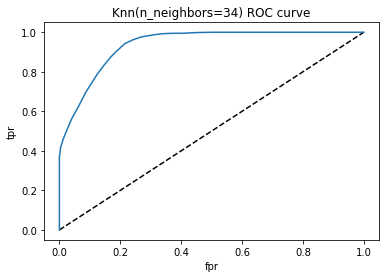

In [27]:
import matplotlib.pyplot as plt

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=34) ROC curve')
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)
x_test.head()

,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing
2119,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2,0,1
9136,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1,2,1,1
7545,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,2,2
7757,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0,2,0
3343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,2


### New prediction

In [29]:
del cleaned_test_set['health_0']
cleaned_test_set.head()

,health_1,social_0,social_1,finance_0,form_0,form_1,form_2,parents,has_nurs,children,housing
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,3,0,0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,3,0,2


In [30]:
arr = knn.predict(cleaned_test_set)
np.savetxt("predicted/pred_knn.csv", np.dstack((np.arange(1, arr.size+1),arr))[0],"%d,%d",header="ID,app_status")


In [31]:
preds

NameError: name 'preds' is not defined